In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request
import scipy.stats

In [3]:
def OneMax(x):
    return x.sum(axis=-1)

In [4]:
def DeceptiveOneMax(x):
    if np.all(x == 0):
        return x.shape[0] + 1
    return np.sum(x)

In [5]:
def KDeceptiveOneMax(k):
    def fun(x):
        n = x.shape[0]
        part_len = n // k
        value = 0
        for j in range(k):
            value += DeceptiveOneMax(x[j*part_len:(j+1)*part_len])
        if part_len * k != n:
            value += DeceptiveOneMax(x[part_len*k:])
        return value
    return fun

In [6]:
def binary_random(p):
    if np.random.uniform(0, 1) < p:
        return 1
    return 0

In [7]:
def initial_probability_vector(d):
    return np.zeros(d) + 0.5

In [8]:
def random_individual(p, d):
    x = np.zeros(d)
    for i in range(d):
        x[i] = np.random.choice(2, p=[1-p[i], p[i]])
    return x

In [9]:
def random_population(p, d, N):
    pop = np.zeros((N, d))
    for k in range(N):
        pop[k, :] = random_individual(p, d)
    return pop

In [10]:
def population_evaluation(pop, F):
    res = np.zeros(pop.shape[0])
    for i in range(pop.shape[0]):
        res[i] = F(pop[i, :])
    return res

In [11]:
# xs = np.clip(xs, min_val, max_val)
def cut_to_zero_one(p):
    if p < 0:
        return 0
    if p > 1:
        return 1
    return p

In [12]:
def PBIL(F, d=10, N=100, Theta1=0.01, Theta2=0.05, Theta3=0.01, T=100, 
         verbose=False, targets=False, probabilities=False):
    if verbose:
        t0 = time.time()
    p = initial_probability_vector(d)
    pop = random_population(p, d, N)
    res = population_evaluation(pop, F)
    if targets:
        target = np.zeros(T)
    if probabilities:
        prob = np.zeros((T, d))
    for t in range(T):
        if verbose and t % 100 == 0:
            print(t, time.time() - t0)
        i = np.argmax(res)
        x = pop[i]
        if targets:
            target[t] = res[i]
        if probabilities:
            prob[t, :] = p
        for k in range(d):
            p[k] = p[k] * (1 - Theta1) + x[k] * Theta1
            p[k] = cut_to_zero_one(p[k])
        for k in range(d):
            if np.random.uniform(0, 1) < Theta2:
                p[k] = p[k] * (1 - Theta3) + binary_random(0.5) * Theta3
            p[k] = cut_to_zero_one(p[k])
        pop = random_population(p, d, N)
        res = population_evaluation(pop, F)
    if verbose:
        print(time.time() - t0)
    if targets and probabilities:
        return p, target, prob
    if targets:
        return p, target
    if probabilities:
        return p, prob
    return p

In [13]:
def CGA(F, d=10, T=100, theta=0.01, verbose=False, targets=False, probabilities=False):
    if verbose:
        t0 = time.time()
    p = initial_probability_vector(d)
    pop = random_population(p, d, 2)
    res = population_evaluation(pop, F)
    if targets:
        target = np.zeros(T)
    if probabilities:
        prob = np.zeros((T, d))
    for t in range(T):
        if verbose and t % 1000 == 0:
            print(t, time.time() - t0)
        if targets:
            i = np.argmax(res)
            target[t] = res[i]
        if probabilities:
            prob[t, :] = p
        indices = np.argsort(res)[::-1]
        pop_s = pop[indices]
        p = p + np.logical_xor(pop_s[0], pop_s[1]) * theta * (pop_s[0] - 0.5) * 2
        p = np.clip(p, 0, 1)
        pop = random_population(p, d, 2)
        res = population_evaluation(pop, F)
    if verbose:
        print(time.time() - t0)
    if targets and probabilities:
        return pop_s[0], target, prob
    if targets:
        return pop_s[0], target
    if probabilities:
        return pop_s[0], prob
    return pop_s[0]

In [14]:
def UMDA(F, d=10, N=100, M=50, T=100, verbose=False, targets=False, probabilities=False):
    if verbose:
        t0 = time.time()
    p = initial_probability_vector(d)
    pop = random_population(p, d, N)
    res = population_evaluation(pop, F)
    if targets:
        target = np.zeros(T)
    if probabilities:
        prob = np.zeros((T, d))
    for t in range(T):
        if verbose and t % 100 == 0:
            print(t, time.time() - t0)
        if targets:
            i = np.argmax(res)
            target[t] = res[i]
        if probabilities:
            prob[t, :] = p
        indices = np.argsort(res)[::-1]
        indices = indices[:M]
        pop_s = pop[indices]
        p = np.sum(pop_s, axis=0) / M
        pop = random_population(p, d, N)
        res = population_evaluation(pop, F)
    if verbose:
        print(time.time() - t0)
    if targets and probabilities:
        return pop_s[0], target, prob
    if targets:
        return pop_s[0], target
    if probabilities:
        return pop_s[0], prob
    return pop_s[0]

# OneMax

In [28]:
p, target, prob = PBIL(OneMax, d=100, N=125, T=200, Theta1=0.05, Theta2=0.10, Theta3=0.01, verbose=True, targets=True, probabilities=True)

0 0.2344045639038086
100 20.922301054000854
41.440105676651


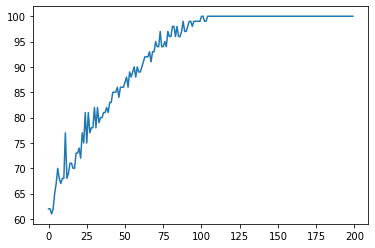

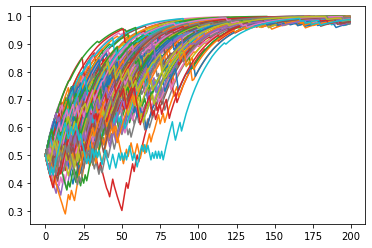

In [29]:
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

In [15]:
best, target, prob = CGA(OneMax, d=100, T=20000, theta=0.01, verbose=True, targets=True, probabilities=True)

0 0.007977724075317383
1000 3.3670272827148438
2000 6.739349126815796
3000 10.266858577728271
4000 13.874827146530151
5000 17.360191106796265
6000 20.749093055725098
7000 24.088732957839966
8000 27.402060985565186
9000 30.684819221496582
10000 34.01893615722656
11000 37.349992513656616
12000 40.611995697021484
13000 43.97949719429016
14000 47.25243520736694
15000 50.52735686302185
16000 53.8704628944397
17000 57.10841703414917
18000 60.38662934303284
19000 63.67100429534912
66.96123838424683


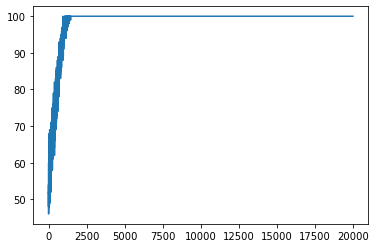

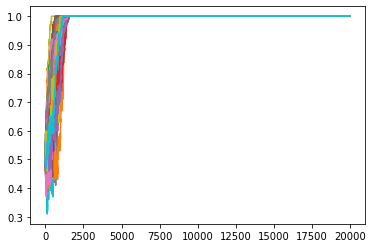

In [16]:
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

In [16]:
best, target, prob = UMDA(OneMax, d=100, N=100, M=50, T=200, verbose=True, targets=True, probabilities=True)

0 0.18650078773498535
100 16.518251180648804
32.75554823875427


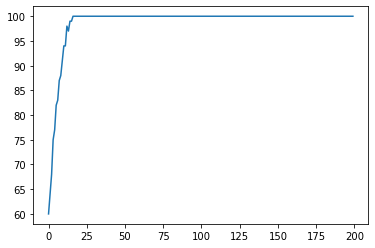

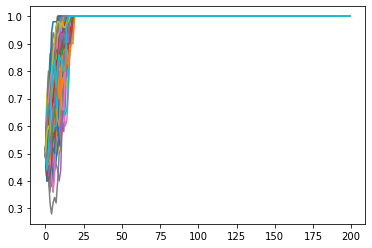

In [17]:
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

# DeceptiveOneMax

In [17]:
p, target, prob = PBIL(DeceptiveOneMax, d=100, N=100, T=200, Theta1=0.05, Theta2=0.10, Theta3=0.01, verbose=True, targets=True, probabilities=True)

0 0.1954784393310547
100 18.784379959106445
36.88456749916077


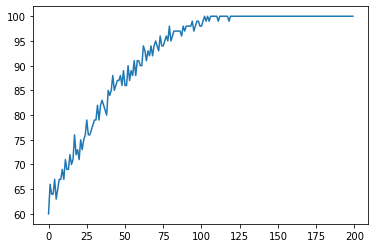

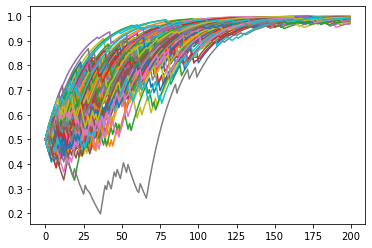

In [18]:
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

In [19]:
best, target, prob = CGA(DeceptiveOneMax, d=100, T=20000, theta=0.01, verbose=True, targets=True, probabilities=True)

0 0.003989219665527344
1000 3.914041519165039
2000 7.555353403091431
3000 11.407065153121948
4000 14.933218240737915
5000 18.87931537628174
6000 22.384490489959717
7000 26.31599521636963
8000 30.177667140960693
9000 33.878283739089966
10000 37.68210983276367
11000 41.51089882850647
12000 45.38853216171265
13000 49.15249300003052
14000 52.962303161621094
15000 56.80505681037903
16000 60.63736319541931
17000 64.43073201179504
18000 68.24453973770142
19000 72.09375882148743
75.9265079498291


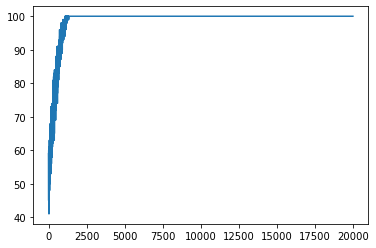

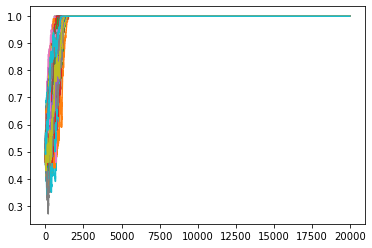

In [20]:
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

In [23]:
best, target, prob = UMDA(DeceptiveOneMax, d=100, N=100, M=50, T=200, verbose=True, targets=True, probabilities=True)

0 0.19248461723327637
100 18.227829933166504
37.12283802032471


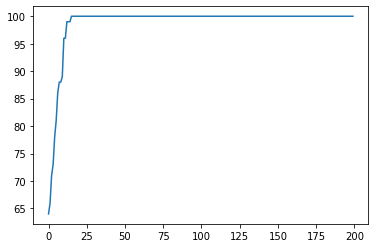

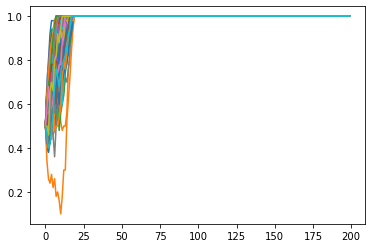

In [24]:
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

# KDeceptiveOneMax

In [25]:
p, target, prob = PBIL(KDeceptiveOneMax(25), d=100, N=100, T=200, Theta1=0.05, Theta2=0.10, Theta3=0.01, verbose=True, targets=True, probabilities=True)

0 0.21342802047729492
100 21.148574113845825
42.153977155685425


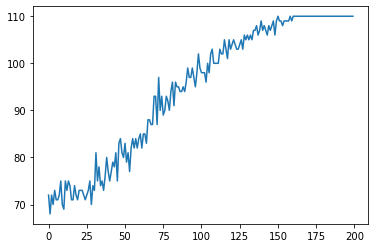

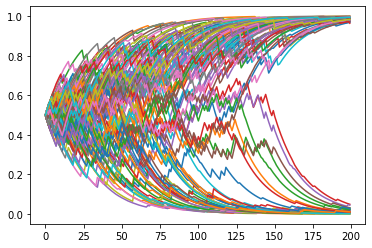

In [26]:
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

In [27]:
best, target, prob = CGA(KDeceptiveOneMax(25), d=100, T=20000, theta=0.01, verbose=True, targets=True, probabilities=True)

0 0.004986286163330078
1000 4.301038026809692
2000 8.338361740112305
3000 12.597017288208008
4000 16.915425300598145
5000 21.216456413269043
6000 25.50199818611145
7000 29.79950785636902
8000 33.589438676834106
9000 37.889933347702026
10000 42.12061953544617
11000 46.413615703582764
12000 50.52266073226929
13000 54.79923057556152
14000 59.06980848312378
15000 63.362327575683594
16000 67.61906099319458
17000 71.88518166542053
18000 76.19665002822876
19000 80.44180607795715
84.51895642280579


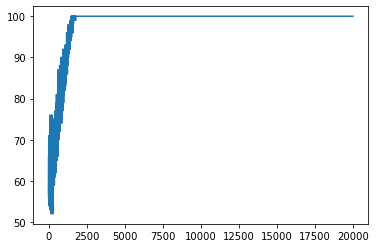

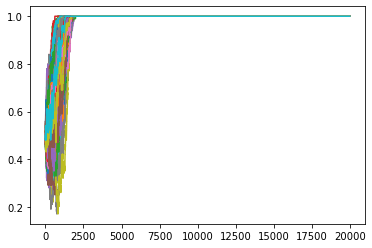

In [28]:
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

In [30]:
best, target, prob = UMDA(KDeceptiveOneMax(25), d=100, N=100, M=50, T=200, verbose=True, targets=True, probabilities=True)

0 0.19151830673217773
100 21.529487133026123
42.677984952926636


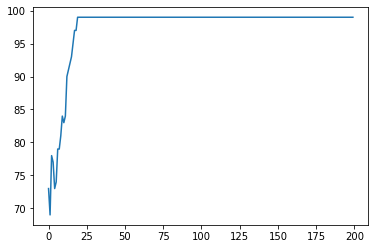

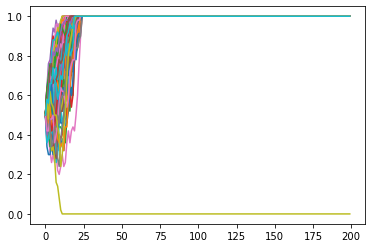

In [31]:
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

0 0.21741795539855957
100 21.321571111679077
41.63542699813843


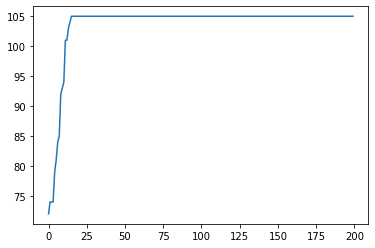

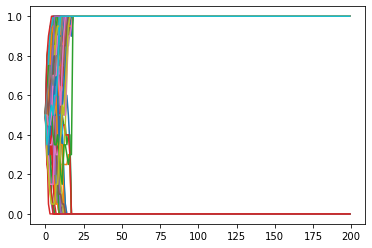

In [32]:
best, target, prob = UMDA(KDeceptiveOneMax(25), d=100, N=100, M=20, T=200, verbose=True, targets=True, probabilities=True)
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

0 0.21641921997070312
10.265196561813354


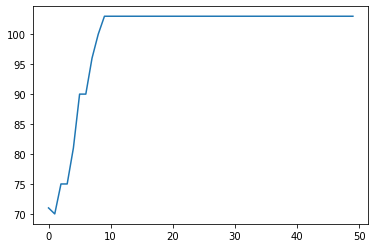

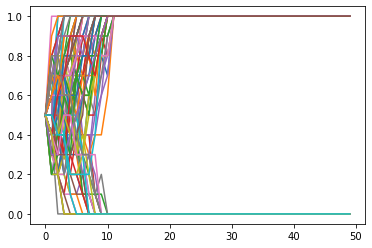

In [33]:
best, target, prob = UMDA(KDeceptiveOneMax(25), d=100, N=100, M=10, T=50, verbose=True, targets=True, probabilities=True)
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

0 0.4388258457183838
21.11277985572815


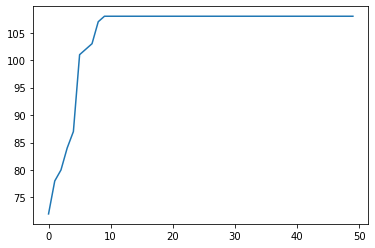

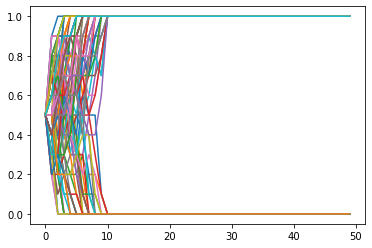

In [34]:
best, target, prob = UMDA(KDeceptiveOneMax(25), d=100, N=200, M=10, T=50, verbose=True, targets=True, probabilities=True)
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

0 0.8547396659851074
25.736860275268555


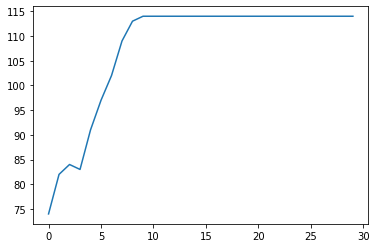

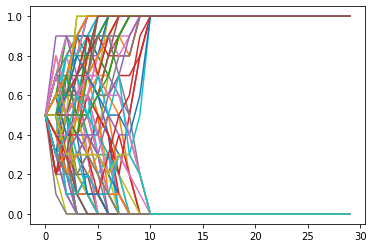

In [35]:
best, target, prob = UMDA(KDeceptiveOneMax(25), d=100, N=400, M=10, T=30, verbose=True, targets=True, probabilities=True)
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

0 1.7184033393859863
51.162858963012695


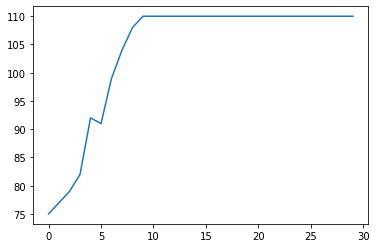

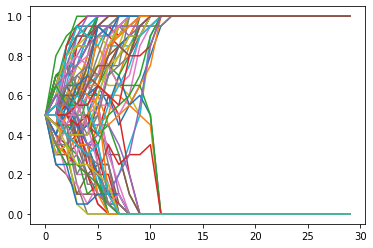

In [36]:
best, target, prob = UMDA(KDeceptiveOneMax(25), d=100, N=800, M=20, T=30, verbose=True, targets=True, probabilities=True)
plt.figure()
plt.plot(target)
plt.show()
plt.figure()
plt.plot(prob)
plt.show()

In [37]:
np.logical_xor(np.array([0,1,0,1]), np.array([0,1,1,0]))+0

array([0, 0, 1, 1])

In [22]:
np.array([[0,1],[2,3]])[0]

array([0, 1])